In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

# 序列模型
概括来说, 序列模型就是根据之前的数据来预测未来可能发生的数据, 但是不同的是, 此时的观测指标是时间等连续变量,比如连续时间马尔可夫链就是一种序列模型
## 统计工具
对于序列数据需要统计工具和新的深度神经万林果架构, 比如以股票价格为例:
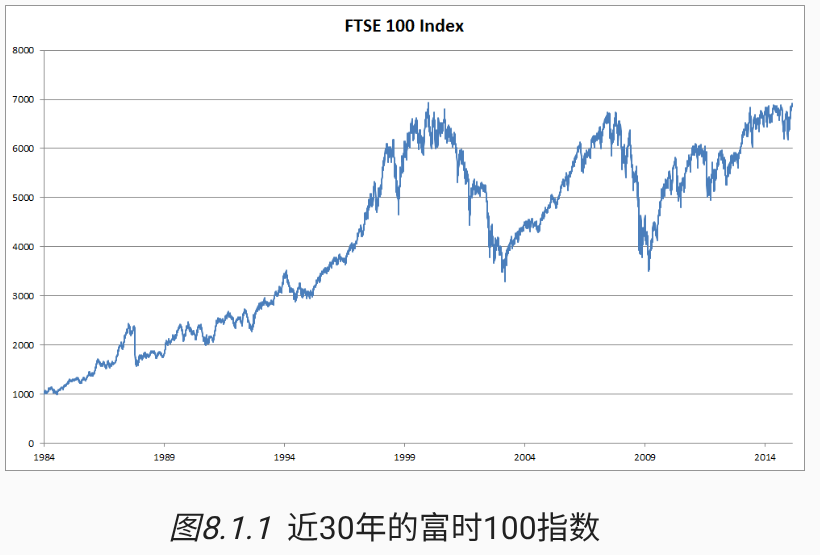
使用 $x_t$ 表示价格, 也就是在时间步 $t \in \mathbb{Z}^+$, 观测到的价格 $x_t$, $t$ 对于本文中的序列通常是离散的, 并且在整数或者其子集上变换, 比如可以通过如下途径预测 $x_t$:
$$
\boldsymbol{x}_t \sim P(\boldsymbol{x}_t \mid \boldsymbol{x}_{t-1}, \ldots, \boldsymbol{x}_1)
$$
### 自回归模型
也就是使用回归模型对于 $x_t$ 进行预测, 但是存在一个主要问题: 输入数据 $x_{t - 1}, ... , x_1$ 随着 $t$ 而变化, 所以输入数据的数量随着遇到的数据量增加而增加, 所以需要一个近似方法来使得计算更加容易, 之后的内容围绕 $P(x_t \mid x_{t - 1}, \ldots , x_1)$ 展开, 归结为如下两种策略:
1. 假设现实情况下相当长的序列 $x_{t - 1}, \ldots, x_1$ 是不必要的, 只需要满足某一个长度为 $\tau$的时间跨度, 也就是只需要使用观测序列 $x_{t - 1}, \ldots , x_{t - \tau}$, 此时参数的数量总是固定的, 此时可以训练一个预测 $x_t$ 的深度网络, 这一种模型称为**自回归模型** (对于平稳序列有效)
2. 第二种策略是保留一些对过去观测的总结 $h_t$, 并且同时更新预测 $\hat{x_t}$ 和总结 $h_t$, 这样就可以产生基于 $\hat{x_t} = P(x_t \mid h_t)$来估计 $x_t$, 以及公式 $h_t = g(h_{t - 1}, x_{t - 1})$更新的模型, 由于其中的 $h_t$ 从来没有被观测过, 所以这一类模型称为隐变量自回归模型, 模型的一般结构如下:
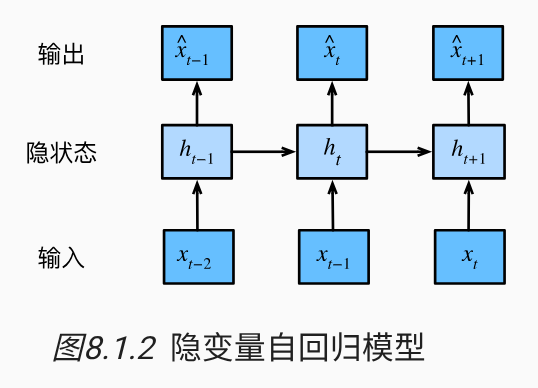
下一个问题是: **如何生成训练数据?**
书中提到一个很有意思的问题: 时间不可能停滞不前, 那么如何获取到训练数据, 我们可以做这样的假设: 序列本身的化变换规律是不变的, 所以也就是只需要找出以往数据的规律即可, 同时整个序列的估计值可以表示为:
$$
P(x_1, \ldots, x_T) = \prod_{t=1}^T P(x_t \mid x_{t-1}, \ldots, x_1)
$$
注意, 如果处理离散的对象(比如单词), 那么上面的考虑依然有效, 唯一的差别就是对于离散的对象, 需要使用分类器而不是回归模型来估计 $P(x_t \mid x_{t - 1}, \ldots , x_1)$ (类似于回归模型和分类问题)

### 马尔可夫模型
自回归模型中, 使用 $x_{t-1}, \ldots , x_{t - \tau}$ 而不是 $x_{t - 1}, \ldots , x_1$ 来估计 $x_t$, 只要这种是近似精确的, 就可以说序列满足马尔可夫条件, 当 $\tau = 1$ 的时候就可以得到一个一阶马尔可夫模型:
$$
P(x_1, \ldots, x_T) = \prod_{t=1}^T P(x_t \mid x_{t-1}) \text{ 当 } P(x_1 \mid x_0) = P(x_1).
$$
当假设 $x_t$ 仅是离散值的时候, 这些模型效果比较好, 利用动态规划可以沿着马尔可夫链精确的计算结果, 比如可以计算 $P(x_{t+1} \mid x_{t-1})$:
$$
\begin{align*}
P(x_{t+1} \mid x_{t-1}) &= \frac{\sum_{x_t} P(x_{t+1}, x_t, x_{t-1})}{P(x_{t-1})} \\
&= \frac{\sum_{x_t} P(x_{t+1} \mid x_t, x_{t-1}) P(x_t, x_{t-1})}{P(x_{t-1})} \\
&= \sum_{x_t} P(x_{t+1} \mid x_t) P(x_t \mid x_{t-1})
\end{align*}
$$
此时只需要直到一个时间节点对应的 $P(x_t)$ 就可以根据马尔可夫链向前面一直推导

注意马尔科夫链强调当前的状态只于之前有限个状态的输出有关系

### 因果关系
这里主要是强调 $x_{t+1}$ 和 $x_t$ 之间的因果关系, 也就是 $x_t$ 影响 $x_{t+1}$ 的概率大于 $x_{t+1}$ 影响 $x_t$ 的概率 

## 训练
实践: 使用正弦函数和一些可加性噪声生成序列数据, 时间步长为 $1, 2, 3, \ldots , 1000$

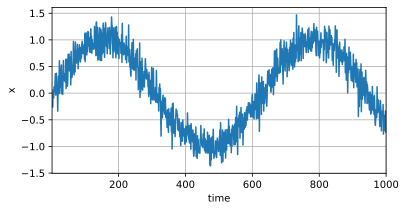

In [41]:
T = 1000 # 时间步长
time = torch.arange(1, T+1, dtype=torch.float32)
x = torch.sin(0.01*time) + torch.normal(0, 0.2, (T,)) # 每一个时间点都有随机噪声
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

接下来需要把序列转换为特征-标签对(这里使用自回归模型对于序列进行预测), 基于嵌入维度 $\tau$, 可以把数据映射为数据对 $y_t = x_t$ 以及 $\mathbf{x}_t = [x_{t - \tau}, \ldots , x_{t - 1}]$, 假设仅仅使用 600 个特征-标签进行训练

In [42]:
tau = 4
features = torch.zeros((T - tau, tau)) # 假设有 4 个特征
# 注意此时的规律  x_(t-1), ... , x_(t-3) -> x_t
for i in range(tau):
    features[:, i] = x[i:T - tau + i]
labels = x[tau:].reshape((-1, 1))
batch_size, n_train = 16, 600
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                           batch_size, is_train=True)

In [43]:
def init_weight(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
def get_net():
    net = nn.Sequential(
        nn.Linear(4, 10),
        nn.ReLU(),
        nn.Linear(10, 1))
    net.apply(init_weight)
    return net
loss = nn.MSELoss(reduction='none')

In [44]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch+1}, '
             f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')
net = get_net()
train(net, train_iter, loss, 10, 0.01)

epoch 1, loss: 0.074552
epoch 2, loss: 0.055579
epoch 3, loss: 0.052380
epoch 4, loss: 0.049559
epoch 5, loss: 0.048950
epoch 6, loss: 0.047202
epoch 7, loss: 0.049345
epoch 8, loss: 0.046767
epoch 9, loss: 0.049031
epoch 10, loss: 0.047190


## 预测
注意上述的模型的作用是输入特征为 $x_{t-1}, x_{t-2}, x{t-3}, x_{t-4}$ 预测 $x_t$ 的值, 取出了 $600$ 个样本

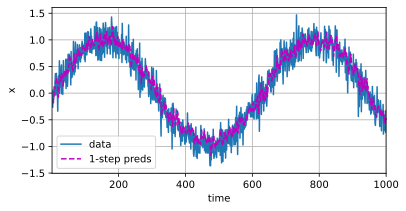

In [45]:
# 首先利用训练集进行预测
onestep_preds = net(features)
d2l.plot([time, time[tau:]], [x.detach().numpy(), onestep_preds.detach().numpy()],
        'time', 'x', legend=['data', '1-step preds'], xlim=[1, 1000],
        figsize=(6, 3))

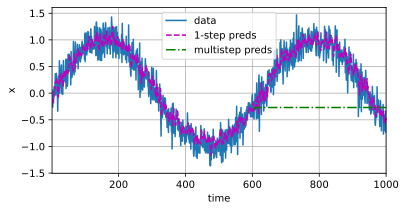

In [46]:
# 根据自己的数据进行预测, 需要预测 604 之后的数据
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

可以发现, 在一段时间之后, 绿线预测的结果不太理想, 此时结果会衰减到一个常数, 原因是错误的积累, 经过各种错误的积累, 误差会很快偏离真实的观测结果, 所以一段时间之后, 预测的效果比较差

假设基于 $k = 1, 4, 16, 24$ 通过对于整个序列预测的计算, 可以看一下 $k$ 部预测的困难

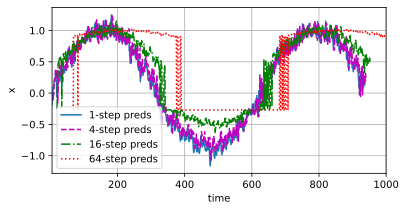

In [47]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))

可以发现当预测更元的未来的时候, 预测的质量会发生变化, 注意上面提到的 $k$ 部分预测表示使用 $k$, 作为时间步, 也就是利用 $x_{t - k}, x_{t - 2k}, x_{t - 3k}, x_{t - 4k}$ 对于 $x_t$ 进行预测 